<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px">

## Conservative regridding using xESMF - conservative_normed method

### Example with orca 2.3 configuration

- Author: Patrick Brockmann
- Version: 18/10/2022

#### Sources:
 * https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html
 *  https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html
 *  https://pavics-sdi.readthedocs.io/en/latest/notebooks/regridding.html

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
print(xr.__version__)

2022.3.0


In [2]:
import xesmf as xe
print(xe.__version__)

0.6.3


In [3]:
import cartopy
import cartopy.crs as ccrs
print(cartopy.__version__)

0.21.0


In [4]:
import cf_xarray
print(cf_xarray.__version__)

0.7.4


In [5]:
ds1 = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/tgcc_thredds/work/p86mart/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/OCE/Analyse/TS_MO/TR5AS-Vlr01_70000101_79991231_1M_tos.nc")
ds1

<xarray.Dataset>
Dimensions:               (y: 149, x: 182, deptht: 31, time_counter: 12000,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 7000-01-16 12:00:00 ... 7999-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    tos                   (time_counter, y, x) float32 ...
Attributes:
    name:                            TR5AS-Vlr01_1m
    description:                     Created by xios
    title:                           Created by xios
    Conventions:                     CF-1.5
    production:                      An IPSL model
    timeStamp:                       2018-May-11 23:39:05 CEST
    LongName:                        VLR Holocene transitoire
    history:                         Mon May 14 03:44:59 2018: ncrcat -C --bu...
    nco_openmp_thread_number:        1
    DODS_EXTRA.Unlimited_Dimension:  time_counter

Max : 32.413425
Min : -1.943314


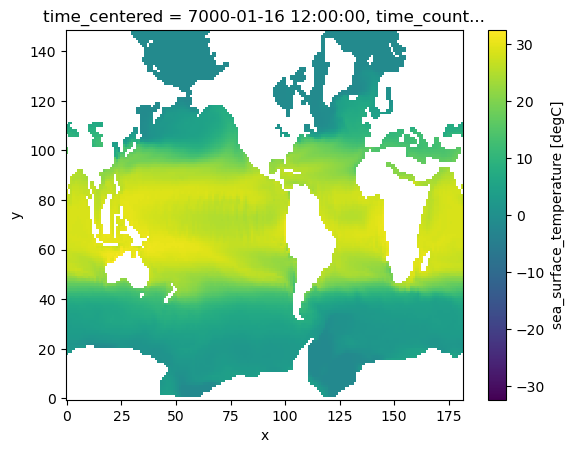

In [6]:
ds1_select = ds1['tos'].isel(time_counter=0)
ds1_select.plot(cmap='viridis')
print("Max : %f\nMin : %f" %(ds1_select.max(), ds1_select.min()))

In [7]:
print("%d" %(ds1_select).count())

16756


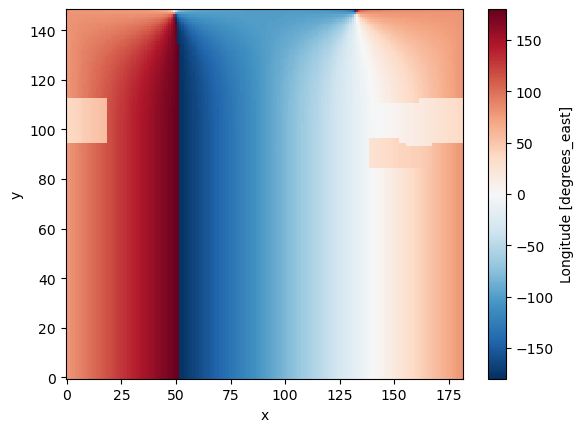

In [8]:
ds1['nav_lon'].plot()

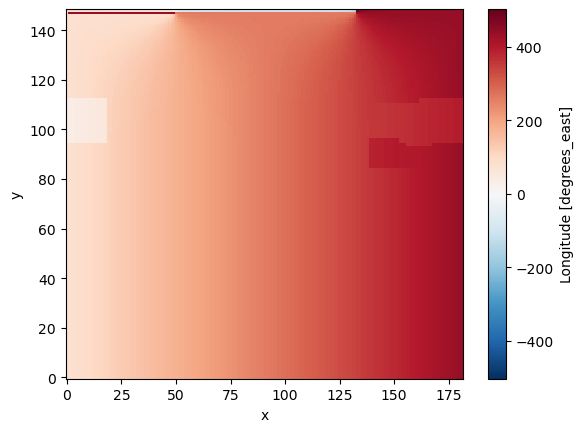

In [9]:
fixed_lons = ds1["nav_lon"].copy()
for i, start in enumerate(np.argmax(np.abs(np.diff(ds1["nav_lon"])) > 180, axis=1)):
    fixed_lons[i, start+1:] += 360
fixed_lons.plot()

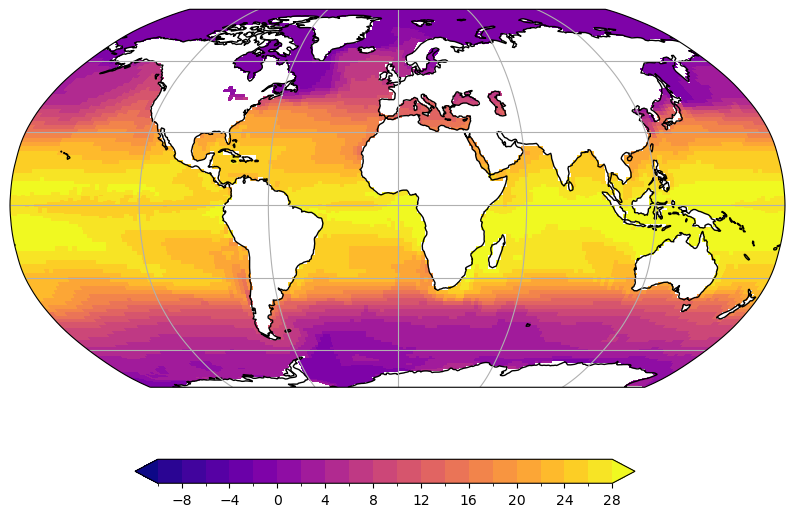

In [10]:
levels = np.arange(-10, 30, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#==================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.pcolormesh(fixed_lons, 
              ds1["nav_lat"], 
              ds1_select, 
              transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show()

In [11]:
ds1Grid = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/tgcc_thredds/work/p86mart/GRAF/DATA/IPSL.ORCA2.3_gridCF.nc")
ds1Grid

<xarray.Dataset>
Dimensions:       (y: 149, x: 182, four: 4, depth: 31, two: 2)
Coordinates:
    lon           (y, x) float32 ...
    lat           (y, x) float32 ...
  * depth         (depth) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x, four, two
Data variables:
    bounds_lon    (y, x, four) float32 ...
    bounds_lat    (y, x, four) float32 ...
    bounds_depth  (depth, two) float32 ...
    MASK          (depth, y, x) float32 ...
    MASKDRAW      (depth, y, x) float32 ...
    AREA          (y, x) float32 ...
    VOL           (depth, y, x) float32 ...
    MBATHY        (y, x) float32 ...
    BATHY         (y, x) float32 ...
Attributes:
    Conventions:  CF-1.1
    institution:  ORCA2.3
    production:   NEMO

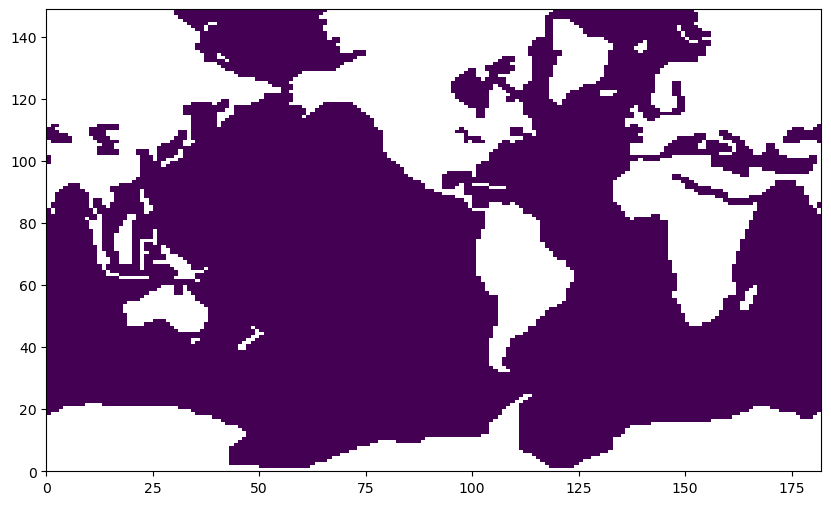

In [12]:
mask = xr.where(ds1Grid['MASKDRAW'].isel(depth=0) == 1, 1, np.nan)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.pcolormesh(mask)

In [13]:
weights = ds1Grid['AREA']
a = ds1_select
a_weighted = a.weighted(weights)
a_masked = ds1_select.where(ds1Grid['MASK'].isel(depth=0) == 1)
a_masked_weighted = a_masked.weighted(weights)

print("========= Non masked\n %d cells" % a.count())
print("average : %f\naverage weigted : %f" % (a.mean(), a_weighted.mean()))

print("========= Masked\n %d cells" % a_masked.count())
print("average : %f\naverage weigted : %f" % (a_masked.mean(), a_masked_weighted.mean()))

========= Non masked
 16756 cells
average : 13.673838
average weigted : 17.745060
========= Masked
 16506 cells
average : 13.739712
average weigted : 17.769432


In [14]:
ds1Grid["bounds_lon"].dims[-1]

'four'

In [15]:
blon = cf_xarray.bounds_to_vertices(ds1Grid["bounds_lon"], ds1Grid["bounds_lon"].dims[-1])
blat = cf_xarray.bounds_to_vertices(ds1Grid["bounds_lat"], ds1Grid["bounds_lat"].dims[-1])
blon

<xarray.DataArray 'bounds_lon' (y_vertices: 150, x_vertices: 183)>
array([[  79.00004 ,   80.99996 ,   82.999886, ...,  439.00003 ,
         440.99997 ,  439.00003 ],
       [  79.00004 ,   80.99996 ,   82.999886, ...,  439.00003 ,
         440.99997 ,  439.00003 ],
       [  79.00004 ,   80.99996 ,   82.999886, ...,  439.00003 ,
         440.99997 ,  439.00003 ],
       ...,
       [  80.070496,   79.929504,   79.86004 , ...,  439.86005 ,
         439.9295  ,  440.0705  ],
       [  80.21581 ,   80.070496,   79.929504, ..., -279.86005 ,
        -279.9295  , -280.0705  ],
       [  80.070496,   80.21581 ,   79.78419 , ..., -279.57355 ,
        -279.78418 , -280.21582 ]], dtype=float32)
Dimensions without coordinates: y_vertices, x_vertices

In [16]:
ds_in = xr.Dataset()
ds_in["mask"] = xr.where(~np.isnan(ds1Grid['MASK'].isel(depth=0).squeeze()), 1, 0)
ds_in["lon_b"] = blon
ds_in["lat_b"] = blat
ds_in

<xarray.Dataset>
Dimensions:  (y: 149, x: 182, y_vertices: 150, x_vertices: 183)
Coordinates:
    lon      (y, x) float32 78.0 80.0 82.0 84.0 ... -279.6 -279.7 -279.8 -280.0
    lat      (y, x) float32 -78.19 -78.19 -78.19 -78.19 ... 51.19 50.52 49.98
    depth    float32 5.0
Dimensions without coordinates: y, x, y_vertices, x_vertices
Data variables:
    mask     (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lon_b    (y_vertices, x_vertices) float32 79.0 81.0 83.0 ... -279.8 -280.2
    lat_b    (y_vertices, x_vertices) float32 -77.98 -77.98 ... 50.19 50.19

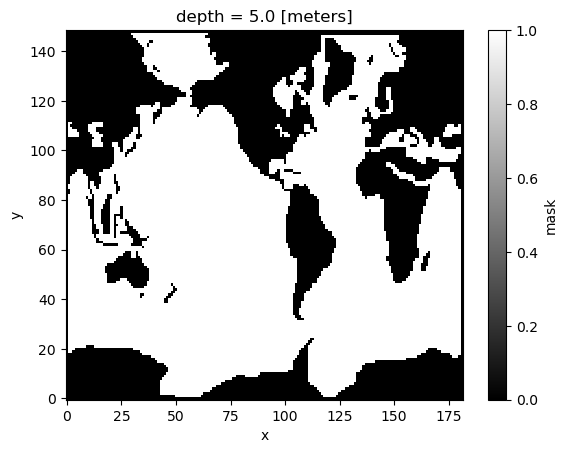

In [17]:
ds_in["mask"].plot(cmap="binary_r")

In [18]:
ds_out = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/grids/etopo60.nc")
ds_out

<xarray.Dataset>
Dimensions:   (ETOPO60X: 360, ETOPO60Y: 180)
Coordinates:
  * ETOPO60X  (ETOPO60X) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * ETOPO60Y  (ETOPO60Y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    ROSE      (ETOPO60Y, ETOPO60X) float32 ...
Attributes:
    history:  FERRET V4.45 (GUI) 22-May-97

In [19]:
ds_out = ds_out.rename({"ETOPO60X": "lon", "ETOPO60Y": "lat"})
ds_out

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180)
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    ROSE     (lat, lon) float32 2.814e+03 2.814e+03 ... -4.317e+03 -4.317e+03
Attributes:
    history:  FERRET V4.45 (GUI) 22-May-97

<function matplotlib.pyplot.show(close=None, block=None)>

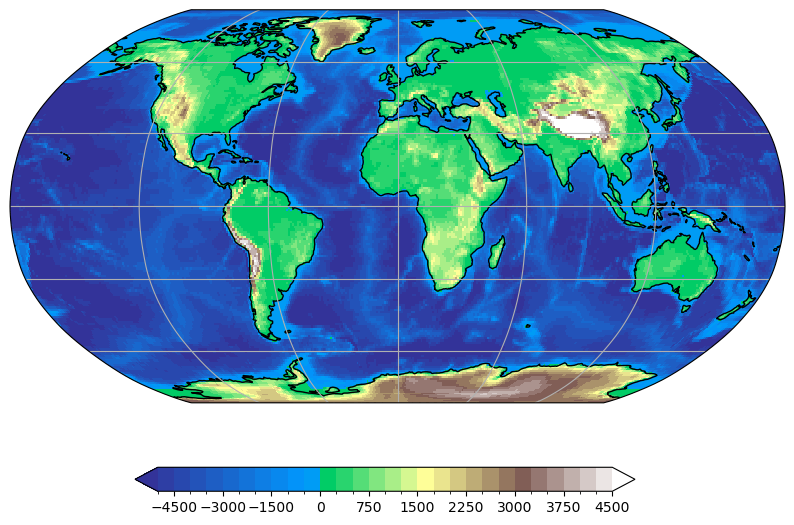

In [20]:
delta = 500 ; levels_undersea = np.arange(-5000, 0, delta)
delta= 250 ; levels_land = np.arange(0, 4500+delta, delta)
levels = np.concatenate((levels_undersea, levels_land))

#  https://matplotlib.org/stable/tutorials/colors/colormapnorms.html#twoslopenorm-different-mapping-on-either-side-of-a-center
colors_undersea = plt.cm.terrain(np.linspace(0, 0.16, len(levels_undersea)+1))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, len(levels_land)))
colors = np.concatenate((colors_undersea, colors_land))

cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#=============================================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.pcolormesh(ds_out['lon'], 
              ds_out['lat'], 
              ds_out['ROSE'], 
              transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show

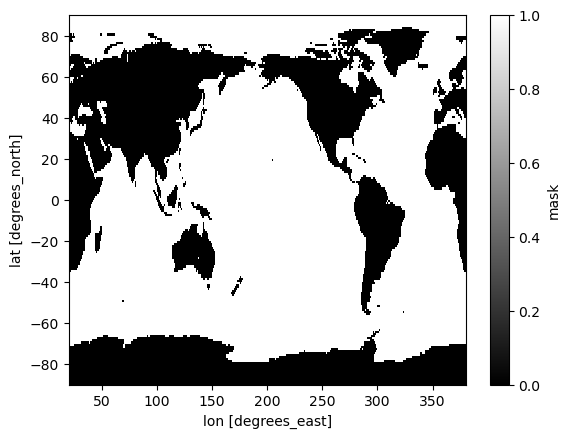

In [21]:
ds_out['mask'] = xr.where(ds_out['ROSE'] >= 0, 0, 1)
ds_out['mask'].plot(cmap="binary_r")

In [22]:
regridder_conservative = xe.Regridder(ds_in, ds_out, "conservative_normed", 
                                      ignore_degenerate=True, periodic=True)

In [23]:
ds2_conservative = regridder_conservative(ds1_select)
ds2_conservative

<xarray.DataArray (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.7419769, -1.7419088, -1.7416443, ..., -1.7421583, -1.7421014,
        -1.742041 ],
       [-1.7414685, -1.7412255, -1.7409996, ..., -1.7423296, -1.7420173,
        -1.7417315],
       [-1.740498 , -1.7404569, -1.7404134, ..., -1.7406073, -1.7405729,
        -1.7405366]], dtype=float32)
Coordinates:
    time_centered  object 7000-01-16 12:00:00
    time_counter   object 7000-01-16 12:00:00
  * lon            (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    regrid_method:  conservative_normed

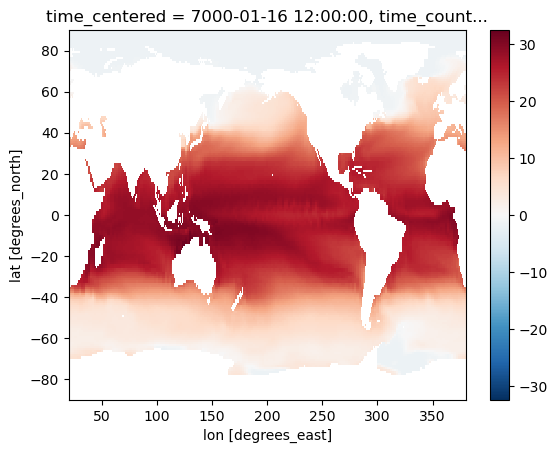

In [24]:
ds2_conservative.plot()

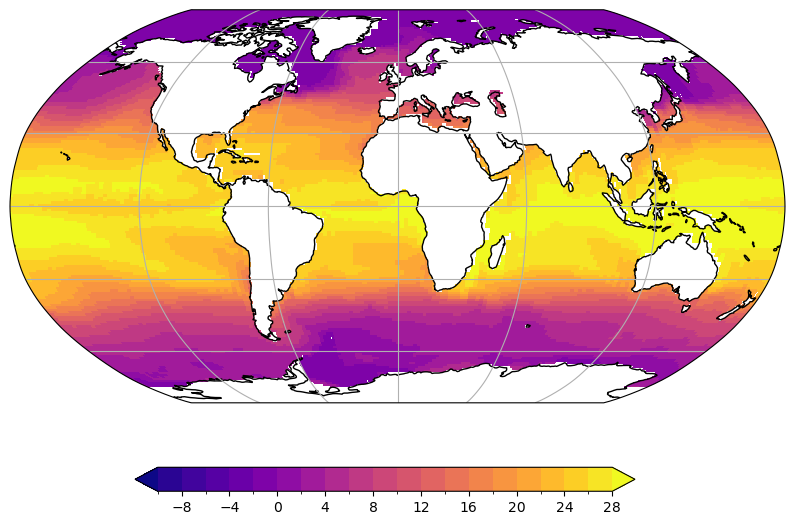

In [25]:
levels = np.arange(-10, 30, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

#==================================
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.pcolormesh(ds2_conservative['lon'], ds2_conservative['lat'], ds2_conservative, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()
ax.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.02, 0.5, 0.04])
matplotlib.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=cmap, orientation='horizontal', extend='both')

#==================================
plt.show()

In [26]:
ds2_conservative.name = "var"
ds2_conservative.to_netcdf("convervative_normed.nc", "w")

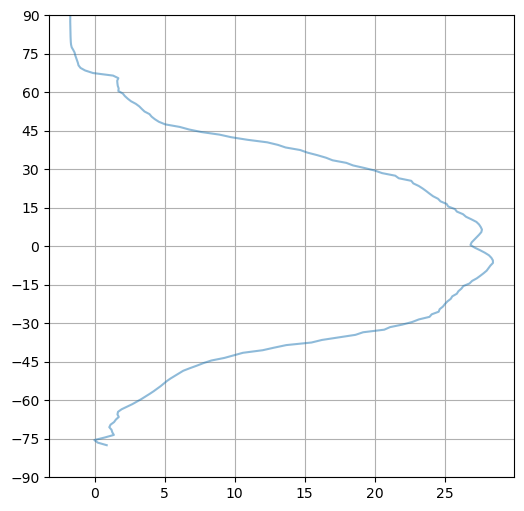

In [27]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)
c = ds2_conservative.mean(('lon'))
ax.plot(c, c.lat, alpha=0.5)
plt.ylim([-90, 90])
plt.yticks(np.arange(-90,90+15,15))
ax.grid()
plt.show()

In [28]:
# https://ferret.pmel.noaa.gov/Ferret/faq/averages-integrals-on-the-sphere
weights = np.cos(np.deg2rad(ds2_conservative.lat))
a = ds2_conservative
a_weighted = a.weighted(weights)
print('conservative_normed')
print("average : %f\naverage weigted : %f" % (a.mean(), a_weighted.mean()))

conservative_normed
average : 13.384249
average weigted : 17.704151
